### Imports and Functions

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import packages.vaccine.helper as hp  # my custom package

# **Part 1.1 MHC I**


# Part 1.1.1: Work

*TODO:
Create and train a regression model for predicting pIC50 values for the data in MHCI_Binding_Data.csv*

*NOTES:*
1. *You only need to make predictions for the 27 alleles in hla_ref_set.class_i.csv*
2. *There are several ways to approach this - please refer to the writeup for ideas/suggestions*

*TODO:
Create a table where each row corresponds to one of the MHC I binding affinity models above, and the final column is the coefficient of determination (i.e. $R^2$) of the model using 5-fold cross validation.*

### 1.1.1. Read in MHC class 1 allele reference set

In [17]:
PATH_TO_REF_SET = 'data/hla_ref_set.class_i.csv'
ref_set_class_i = pd.read_csv(PATH_TO_REF_SET,header=None)

# create a list of alleles
class_i_list = ref_set_class_i[0].tolist()
len(class_i_list)

27

### 1.1.1. Data Exploration

In [18]:
# read in data
PATH_TO_MHC1_DATA = 'data/MHCI_Binding_Data.csv'
MHC1_df = pd.read_csv(PATH_TO_MHC1_DATA) 
print(MHC1_df.shape)
MHC1_df.head(2)

(157325, 6)


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50
0,human,HLA-A*01:01,8,ASFCGSPY,51.400000,7.289037
1,human,HLA-A*01:01,8,LTDFGLSK,739.385479,6.131129


In [19]:
# check whether there are other alleles present we don't care about (we care about 27)
print(len(MHC1_df['HLA Allele'].unique()))

119


In [20]:
# filter out records which are not for the 27 listed alleles
MHC1_filtered_df = MHC1_df[MHC1_df['HLA Allele'].isin(class_i_list)]
print(MHC1_filtered_df.shape)

(111742, 6)


In [21]:
# check how much data we have per allele
MHC1_filtered_df['HLA Allele'].value_counts()

HLA-A*02:01    12160
HLA-A*03:01     7358
HLA-A*11:01     6399
HLA-A*02:03     6303
HLA-A*31:01     5713
HLA-A*02:06     5628
HLA-A*68:02     5545
HLA-A*01:01     4792
HLA-B*07:02     4642
HLA-A*26:01     4535
HLA-B*15:01     4448
HLA-A*68:01     3795
HLA-A*33:01     3597
HLA-B*08:01     3538
HLA-B*40:01     3443
HLA-B*58:01     3350
HLA-A*24:02     3280
HLA-B*35:01     3211
HLA-A*30:01     2925
HLA-B*57:01     2903
HLA-B*51:01     2901
HLA-A*23:01     2641
HLA-B*44:02     2318
HLA-A*30:02     2057
HLA-B*53:01     1720
HLA-B*44:03     1404
HLA-A*32:01     1136
Name: HLA Allele, dtype: int64

In [22]:
# determine if any of the 27 alleles are not represented (there aren't)
print(len(MHC1_filtered_df['HLA Allele'].value_counts()))

27


In [23]:
# check how much data we have per sequence length
MHC1_filtered_df['peptide_length'].value_counts().sort_index()

8      1854
9     83083
10    24300
11     1668
12      140
13      268
14      168
15      206
17       27
18       27
30        1
Name: peptide_length, dtype: int64

In [24]:
# check whether we have any duplicate rows for a given sequence (there aren't)
MHC1_grouped_df = MHC1_filtered_df.groupby(by=['HLA Allele','sequence']).count()
MHC1_grouped_df = MHC1_grouped_df[MHC1_grouped_df['species'] > 1]
print(MHC1_grouped_df.shape[0])

0


In [25]:
# check whether there is data for each allele for sequences of only length 9
MHC1_length_9_df = MHC1_filtered_df[MHC1_filtered_df['peptide_length']==9]
print(len(MHC1_length_9_df['HLA Allele'].unique()))
print()

# confirm how much data we have per sequence length
print(MHC1_length_9_df['peptide_length'].value_counts().sort_index())

# check how much data we have per allele
MHC1_length_9_df['HLA Allele'].value_counts()

27

9    83083
Name: peptide_length, dtype: int64


HLA-A*02:01    9051
HLA-A*03:01    5488
HLA-A*11:01    4544
HLA-A*02:03    4428
HLA-B*15:01    4101
HLA-A*31:01    3945
HLA-A*01:01    3902
HLA-B*07:02    3868
HLA-A*26:01    3766
HLA-A*02:06    3733
HLA-A*68:02    3672
HLA-B*08:01    3027
HLA-B*58:01    2984
HLA-B*40:01    2824
HLA-A*30:01    2565
HLA-B*57:01    2529
HLA-B*35:01    2514
HLA-A*24:02    2395
HLA-B*51:01    2239
HLA-A*68:01    2036
HLA-A*33:01    1929
HLA-A*23:01    1915
HLA-B*44:02    1682
HLA-A*30:02    1330
HLA-B*53:01    1052
HLA-A*32:01     831
HLA-B*44:03     733
Name: HLA Allele, dtype: int64

### 1.1.1. Data Prep
Most of the data is concentrated with sequences of length 9 and 10. Let's use only sequences of length 9 to build the regression model.

In [26]:
# read in data
PATH_TO_MHC1_DATA = 'data/MHCI_Binding_Data.csv'
MHC1_df = pd.read_csv(PATH_TO_MHC1_DATA) 

# filter out records with sequence length not equal to 9
MHC1_df = MHC1_df[MHC1_df['peptide_length']==9]

# filter out records which are not for the 27 listed alleles
MHC1_df = MHC1_df[MHC1_df['HLA Allele'].isin(class_i_list)]

MHC1_df.shape

(83083, 6)

In [27]:
# add a column with the standard 9-length sequence for every record
MHC1_df.loc[:, ('seq_standard')]=MHC1_df.apply(lambda x: hp.get_n_length_seq(x['sequence'],9),axis=1)
MHC1_df.head(2)

,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard
69,human,HLA-A*01:01,9,CSDAFYPFY,1.0,9.0,CSDAFYPFY
70,human,HLA-A*01:01,9,CSDETTLYY,1.0,9.0,CSDETTLYY


###  1.1.1. Encode the sequence into feature columns
- Split 9 sequence into one column per letter.
- Use ASCII number for each letter to convert to numerical data to use for regression.

In [28]:
# encode letter as ASCII number
col_list = ['s1','s2','s3','s4','s5','s6','s7','s8','s9']
MHC1_df[col_list]=MHC1_df.seq_standard.apply(lambda x: pd.Series([ord(char) for char in str(x)]))
MHC1_df.head(1)

,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard,s1,s2,s3,s4,s5,s6,s7,s8,s9
69,human,HLA-A*01:01,9,CSDAFYPFY,1.0,9.0,CSDAFYPFY,67,83,68,65,70,89,80,70,89


### 1.1.1. Data Visualization
To help see what type of regression model best fits the data.

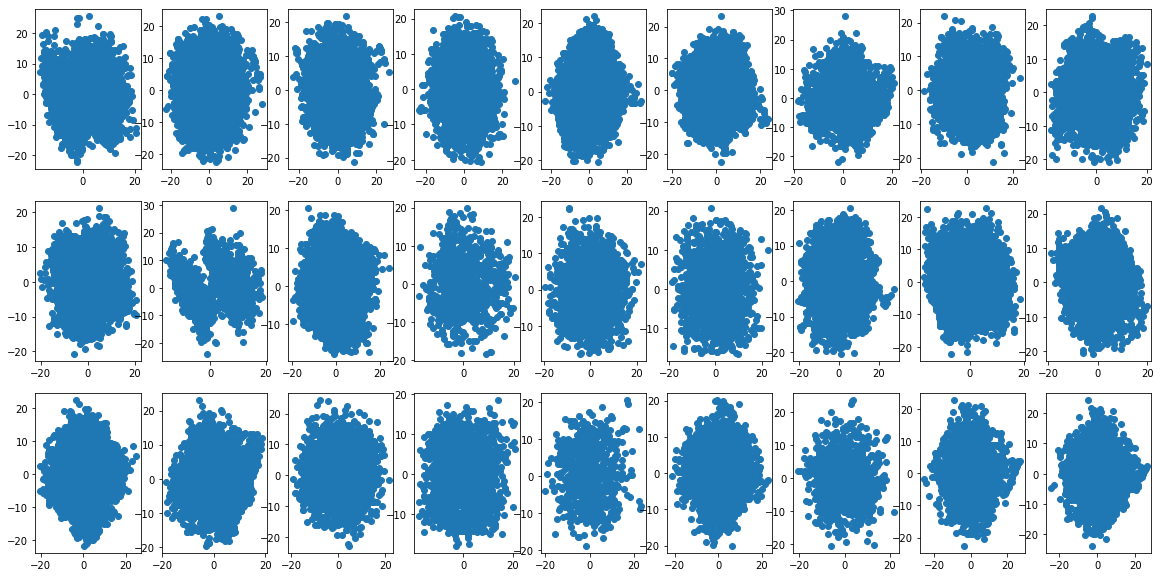

In [29]:
hp.plot_separate_alleles(MHC1_df,class_i_list)


### 1.1.1. Train Regression Models


In [ ]:
%%time

# for each of the 27 alleles, learn a separate regression model
regression_scores_mhc1 = []
for allele in class_i_list:
    m,s = hp.score_regression_model(MHC1_df,allele)
    result = [allele,round(s,5),round(m,5)] # std_dev before mean
    regression_scores_mhc1.append(result)
    

### 1.1.1. Output Results

In [ ]:
# output results
mhc1_regression_scores_df = pd.DataFrame(data=regression_scores_mhc1,columns = ['Allele','Std_dev','R_2'])
print(mhc1_regression_scores_df.shape)
mhc1_regression_scores_df


## Part 1.1.1: Answer

*Briefly describe your approach for creating the regression model. Include the table as the output of the cell above or embed it as an image in this cell.*

#### Data
First, I filtered out records from the MHC I binding data which were not for the alleles listed in the reference set. Additionally, I noticed that the vast majority of data for MHC I centered around a peptide length of 9, so I chose to limit my model to predicting pIC50 values for peptides of length 9. This allowed me to filter out records from the MHC I binding data which were not of length 9.

From there, I encoded the peptide sequence by splitting each amino acid letter into its own column, the calculating the ASCII value for each letter. This results in a feature set of numerical values for the regression model.


#### Regression Model
I decided to create a different model for each allele in the reference set, rather than include the allele in the feature data. This ensures that the line of best fit found by the model is not influenced by the allele itself. By creating separate models, I prevent any relationship between alleles from manipulating the fit.

I then attempted to visualize the features with PCA. This helped inform me that the data isn't really linear in nature. I chose to use a Random Forest regression for this reason, rather than use linear regression.



# Part 1.1.2: Work

*TODO: Create and train a regression model for predicting pIC50 values for the data in MHCII_Binding_Data.csv*

*NOTES:*
1. *You only need to make predictions for the 27 alleles in hla_ref_set.class_i.csv*
2. *There are several ways to approach this - please refer to the writeup for ideas/suggestions*

*TODO: Create a table where each row corresponds to one of the MHC II binding affinity models above, and the final column is the Coefficient of determination (ie. $R^2$) of the model using 5-fold cross validation.*

### 1.1.2. Read in MHC class 2 allele reference set

In [ ]:
PATH_TO_REF_SET = 'data/hla_ref_set.class_ii.csv'
ref_set_class_ii = pd.read_csv(PATH_TO_REF_SET,header=None)

# create a list of alleles
class_ii_list = ref_set_class_ii[0].tolist()
len(class_ii_list)

### 1.1.2 Data Exploration

In [ ]:
# read in data
PATH_TO_MHC2_DATA = 'data/MHCII_Binding_Data.csv'
MHC2_df = pd.read_csv(PATH_TO_MHC2_DATA) 
print(MHC2_df.shape)
MHC2_df.head(2)

In [ ]:
# rename allele column to match MHC1 data
MHC2_df = MHC2_df.rename(columns={"mhc": "HLA Allele"})

In [ ]:
# check whether there are other alleles present we don't care about (there aren't)
print(len(MHC2_df['HLA Allele'].unique()))

In [ ]:
# filter out records which are not for the 27 listed alleles
MHC2_filtered_df = MHC2_df[MHC2_df['HLA Allele'].isin(class_ii_list)]
print(MHC2_filtered_df.shape)

# check how much data we have per allele
MHC2_filtered_df['HLA Allele'].value_counts()

In [ ]:
# determine if any of the 27 alleles are not represented
print(len(MHC2_filtered_df['HLA Allele'].value_counts()))

# determine which are missing
included = list(MHC2_filtered_df['HLA Allele'].value_counts().index)
missing = [each for each in class_ii_list if each not in included]
missing

In [ ]:
# check how much data we have per sequence length
MHC2_filtered_df['peptide_length'].value_counts().sort_index()

In [ ]:
# check whether we have any duplicate rows for a given sequence
MHC2_grouped_df = MHC2_filtered_df.groupby(by=['HLA Allele','sequence']).count()
MHC2_grouped_df = MHC2_grouped_df[MHC2_grouped_df['species'] > 1]
print(MHC2_grouped_df.shape[0])

In [ ]:
# check whether there is data for each allele for sequences of only length 15
MHC2_length_15_df = MHC2_filtered_df[MHC2_filtered_df['peptide_length']==15]
print(len(MHC2_length_15_df['HLA Allele'].unique()))
print()

# check how much data we have per sequence length
print(MHC2_length_15_df['peptide_length'].value_counts().sort_index())

# check how much data we have per allele
MHC2_length_15_df['HLA Allele'].value_counts()

### 1.1.2 Data Prep
Most of the data is concentrated with sequences of length 15. Let's use only sequences of length 15 to build the regression model.

In [ ]:
# read in data
PATH_TO_MHC2_DATA = 'data/MHCII_Binding_Data.csv'
MHC2_df = pd.read_csv(PATH_TO_MHC2_DATA) 

# rename allele column to match MHC1 data
MHC2_df = MHC2_df.rename(columns={"mhc": "HLA Allele"})

# filter out records with sequence length not equal to 15
MHC2_df = MHC2_df[MHC2_df['peptide_length']==15]

# filter out records which are not for the 27 listed alleles
MHC2_df = MHC2_df[MHC2_df['HLA Allele'].isin(class_ii_list)]

MHC2_df.shape

In [ ]:
# add a column with the 15-length sequence for every record
MHC2_df.loc[:, ('seq_standard')]=MHC2_df.apply(lambda x: hp.get_n_length_seq(x['sequence'],15),axis=1)
MHC2_df.head(2)

### 1.1.2. Encode the sequence into feature columns
- Split 15 sequence into one column per letter.
- Use ASCII number for each letter to convert to numerical data to use for regression.

In [ ]:
# encode letter as ASCII number
col_list = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15']
MHC2_df[col_list]=MHC2_df.seq_standard.apply(lambda x: pd.Series([ord(char) for char in str(x)]))
MHC2_df.head(2)

### Data Visualization
To help see what type of regression model best fits the data.

In [ ]:
hp.plot_separate_alleles(MHC2_df, class_ii_list)

In [ ]:
%%time

# for each of the 27 alleles, learn a separate regression model
regression_scores_mhc2 = []
for allele in class_ii_list:
    m,s = hp.score_regression_model(MHC2_df,allele)
    result = [allele,round(s,5),round(m,5)] # std_dev before mean
    regression_scores_mhc2.append(result)

In [ ]:
mhc2_regression_scores_df = pd.DataFrame(data=regression_scores_mhc2,columns = ['Allele','Std_dev','R_2'])
print(mhc2_regression_scores_df.shape)
mhc2_regression_scores_df


# Part 1.1.2: Answer

*Briefly describe your approach for creating the regression model. Include the table as the output of the cell above or embed it as an image in this cell.*

#### Data
First, I filtered out records from the MHC II binding data which were not for the alleles listed in the reference set. Additionally, I noticed that the vast majority of data for MHC II centered around a peptide length of 15, so I chose to limit my model to predicting pIC50 values for peptides of length 15. This allowed me to filter out records from the MHC II binding data which were not of length 15.

From there, I encoded the peptide sequence by splitting each amino acid letter into its own column, the calculating the ASCII value for each letter. This results in a feature set of numerical values for the regression model.


#### Regression Model
I decided to create a different model for each allele in the reference set, rather than include the allele in the feature data. This ensures that the line of best fit found by the model is not influenced by the allele itself. By creating separate models, I prevent any relationship between alleles from manipulating the fit.

I then attempted to visualize the features with PCA. This helped inform me that the data isn't really linear in nature. I chose to use a Random Forest regression for this reason, rather than use linear regression.

# Part 1.2 Binding Prediction

# Part 1.2: Work 

*TODO: Split protein sequence from `SARS-CoV2-Spike.fasta` into 
overlapping k-mers for your choice of k.*

*TIP: The `.fasta` files usually start with some header describing the meta information. 
     The code below skips the header and joins the lines of the sequence to obtain
     the full protein sequence.*

### 1.2. Read spike sequence

In [ ]:
# build character array of full sequence
PATH_TO_FASTA = 'data/SARS-CoV2-Spike.fasta' 
spike_sequence = hp.get_spike_sequence(PATH_TO_FASTA)
spike_array = hp.get_spike_array(spike_sequence)
assert len(spike_sequence) == len(spike_array)
len(spike_array)

### 1.2. Split spike sequence into k-mers
My method is to use a generator to return k-mers one at a time, rather than need to store all k-mers in a data structure. The generator terminates when there all k-mers have been generated.

## Part 1.2: Answer

*What was the value of k you used to create the overlapping k-mers?*

For MHC I data, I used a value of k=9. For MHC II data, I used a value of k=15.

# Part 1.3

## Part 1.3: Work

*TODO:* 
1. *Apply the models you created in part 1.1 to the k-mers you created in part 1.2.*
2. *Store the returned labeled (MHC, peptide) pairs where the label is the predicted pIC50 value.*
3. *Determine the min, max, mean, median, and std. dev of the predicted pIC50 values for each MHC class.*

### 1.3. Define algorithm for estimating pIC50 for Spike Protein k-mers
Generate a set of labeled (MHC,peptide) pairs, where the label is the predicted pIC50 value.

In [ ]:
seq = hp.get_spike_array('CVADYSVLY')
seq

In [ ]:
print('test predict_pIC50_values_for_allele()')

test_df = MHC1_df[MHC1_df['seq_standard'] == 'CVADYSVLY']
print(test_df.shape)

# train model for this allele
test_model = hp.train_regresson_model(MHC1_df,'HLA-A*01:01')

test_results = hp.predict_pIC50_values_for_allele(test_df, test_model, 'HLA-A*01:01', spike_array, 9)

In [ ]:
for each in test_results:
    if round(each[4],2) == 7.87:
        print(each)

In [ ]:
print('test predict_pIC50_values()')

# test for 2 k-mers to ensure the correct number of results are found
test_array = spike_array[359:369]
print(test_array)

test_alleles = class_i_list[:2]
print(test_alleles)

test_results = hp.predict_pIC50_values(test_alleles,MHC1_df,test_array,9)
print(len(test_results))

In [ ]:
test_results

In [ ]:
# test for MHC II to ensure the correct number of results are found
# 3 alleles currently have no data so there should be 48 results

test_array = spike_array[:16]
test_results = hp.predict_pIC50_values(class_ii_list,MHC2_df,test_array,15)
print(len(test_results))

### 1.3. Apply pIC50 Algorithm to MHC I  data

In [ ]:
%%time

# 9 min for RandomForest with max_depth=2, random_state=0
results_mhc1 = hp.predict_pIC50_values(class_i_list,MHC1_df,spike_array,9)

In [ ]:
# validate result

# There are 1265 9-mers over sequence of 1273 letters
expected = 27 * 1265
actual = len(results_mhc1)
assert expected == actual,actual

In [ ]:
# check whether results are reasonable
for each in results_mhc1:
    if each[1] == 'CVADYSVLY':
        print(each)

### 1.3. Apply pIC50 Algorithm to MHC II  data

In [ ]:
%%time

# 6 min for RandomForest with max_depth=2, random_state=0
results_mhc2 = hp.predict_pIC50_values(class_ii_list,MHC2_df,spike_array,15)

In [ ]:
# validate result

# There are 1259 15-mers over sequence of 1273 letters
# 3 alleles have no data
expected = 24 * 1259
actual = len(results_mhc2)
assert expected == actual,actual

### 1.3. Calculate metrics for table

In [ ]:
# calculate metrics for MHC I
mch1_metrics = hp.calculate_metrics('I',results_mhc1)

# calculate metrics for MHC II
mch2_metrics = hp.calculate_metrics('II',results_mhc2)

# format results into a table
data_1_3 = [mch1_metrics,mch2_metrics]
df_1_3 = pd.DataFrame(data=data_1_3,columns = ['MHC Class','Min','Max','Mean','Median','Std Dev'])
df_1_3

## Part 1.3: Answer

*If you would like to manually fill in the table provided in the write-up, please replace the empty table below with a screenshot of your filled in table. Alternatively, you could display the table as the output of the above cell as long as it contains all of the relevant information.*

# Part 1.4

## Part 1.4: Work
*TODO:*
1. *Devise and implement an algorithm for selecting SARS-CoV-2 peptides from the set you created in part 1.3 that maximizes the ‘allele coverage’. Please refer to the write-up for definitions and constraints.*
2. *Use your algorithm to compute the values required for the tables in the cell below.*

### 1.4 Min Selection Algorithm Part 1 - Build Coverage DataFrame
- Take the predictions made for all k-mers in the spike sequence
- Limit predictions to peptides with pIC50 value greater than p_min
- Create a DataFrame which lists 
  - peptide k-mer from spike sequence
  - start position in the spike sequence
  - end position in the spike sequence
  - for each allele in the reference set
    - a flag which denotes if the allele is covered by this peptide 
    - (1 if covered, 0 otherwise)
  - count column which sums all allele flags for this peptide

In [ ]:
def get_list_above_p_min(predictions,p_min):
    '''
    Returns a list of predictions which have a pIC50 value above p_min.
    '''
    
    results = []
    
    for prediction in predictions:
        pIC50 = prediction[4]
        if pIC50 >= p_min:
            results.append(prediction)
    
    return results


print('test get_list_above_p_min()')
print(len(results_mhc1))
print()
print(len(get_list_above_p_min(results_mhc1,9.0)))
print(len(get_list_above_p_min(results_mhc1,8.0)))
print(len(get_list_above_p_min(results_mhc1,7.0)))
print(len(get_list_above_p_min(results_mhc1,6.0)))
print(len(get_list_above_p_min(results_mhc1,5.0)))
print(len(get_list_above_p_min(results_mhc1,4.0)))
print(len(get_list_above_p_min(results_mhc1,3.0)))

get_list_above_p_min(results_mhc1,9.0)

In [ ]:
def get_peptide_coverage_dict(predictions_list):
    '''
    Builds and returns a dictionary in which keys are every 
    peptide in the prediction list and the value for each 
    key is a set of alleles which are covered by that peptide.
    '''
    
    # maintain a set of peptides which cover each allele
    coverage_dict = dict()

    for allele,peptide,start,end,pIC50 in predictions_list:
        
        # define key to avoid collisions
        key = peptide + '_' + str(start) + '_' + str(end)
        
        if key in coverage_dict:
            # append allele to the list
            coverage_dict[key].add(allele)
        else:
            # add set to dictionary
            new_set = set()
            new_set.add(allele)
            coverage_dict[key] = new_set
     
    return coverage_dict


print('test get_peptide_coverage_dict()')
test_above = get_list_above_p_min(results_mhc1,9.0)
test_d = get_peptide_coverage_dict(test_above)
test_d

In [ ]:
def build_row_df(coverage_dict,key,alleles):
    '''
    Builds and returns a DataFrame consisting of a single row
    with the following columns:
    
    - peptide
    - start position
    - end position
    - allele flag for each allele in alleles
    - count
    
    Allele flag is 1 if allele binds with this peptide,
    0 otherwise.
    
    Count is a sum of all allele flags for this peptide 
    '''
    
    peptide,start,end=key.split('_')

    new_dict = dict()
    new_dict['peptide']=[peptide]
    new_dict['start']=[int(start)]
    new_dict['end']=[int(end)]

    # create row for DataFrame of all alleles
    counter = 0
    for allele in alleles:

        if allele in coverage_dict[key]:
            new_dict[allele] = [1]
            counter += 1
        else:
            new_dict[allele] = [0]

    new_dict['count'] = [counter]
    return pd.DataFrame.from_dict(new_dict)


print('test build_row_df()')
test_row = build_row_df(test_d,'FIAGLIAIV_1219_1227',class_i_list)
test_row.T

In [ ]:
def build_peptide_coverage_df(coverage_dict,alleles):
    '''
    Builds and returns a DataFrame which contains a row for 
    each peptide in the coverage dictionary with columns
    for each allele in alleles.
    '''
    
    counter = 0
    df = None
    for key in coverage_dict:
        
        # build row
        df_row = build_row_df(coverage_dict,key,alleles)
        
        if counter == 0:
            df = df_row
        else:
            df = df.append(df_row)
        
        counter += 1
    return df


print('test build_peptide_coverage_df()')
test_coverage_df = build_peptide_coverage_df(test_d, class_i_list)
test_coverage_df

In [ ]:
def get_peptide_coverage_df(predictions_list,p_min,alleles):
    '''
    Selects from the given predictions list those
    peptides which have pIC50 at or above p_min, then
    builds a DataFrame representing the allele coverage
    for each of the selected peptides.
    '''
    above = get_list_above_p_min(predictions_list,p_min)
    if len(above) > 0:
        p_dict = get_peptide_coverage_dict(above)
        df = build_peptide_coverage_df(p_dict, alleles)
    else:
        df = pd.DataFrame() # empty DataFrame
    return df
    
print('test get_peptide_coverage_df()')

test_coverage_df = get_peptide_coverage_df(results_mhc1,10.0,class_i_list)
print(len(test_coverage_df))

test_coverage_df = get_peptide_coverage_df(results_mhc1,9.0,class_i_list)
test_coverage_df

### 1.4 Min Selection Algorithm Part 2 - Select Peptides for Minimum Coverage
Choose peptides which cover as many alleles as possible.

In [ ]:
# check coverage of alleles mhc 1

for p_min in [3.0,6.0,9.0]:
    mhc1_coverage_df = get_peptide_coverage_df(results_mhc1,p_min,class_i_list)
    a = pd.DataFrame(mhc1_coverage_df.drop(['peptide','start','end','count'],axis=1).sum(axis=0).sort_values(),columns=['total']).reset_index()
    a.rename(columns={'index':'HLA Allele'})
    print(a[a['total'] > 0].shape[0])

In [ ]:
# check coverage of alleles mhc 2

for p_min in [3.0,6.0,9.0]:
    df_coverage_mhc2 = get_peptide_coverage_df(results_mhc2,p_min,class_ii_list)
    a = pd.DataFrame(df_coverage_mhc2.drop(['peptide','start','end','count'],axis=1).sum(axis=0).sort_values(),columns=['total']).reset_index()
    a.rename(columns={'index':'HLA Allele'})
    print(a[a['total'] > 0].shape[0])

In [ ]:
def get_allele_least_coverage(df_coverage,uncovered):
    '''
    Given the peptide coverage DataFrame, returns the 
    allele with the minimum number of peptides that cover it
    which has a coverage greater than zero.
    '''
    # sum the coverage for each allele column
    # then sort the values so the smallest count is at the top
    counted_and_sorted_series = df_coverage.drop(['peptide','start','end','count'],axis=1).sum(axis=0).sort_values()
    df = pd.DataFrame(counted_and_sorted_series,columns=['total']).reset_index()
    df = df.rename(columns={'index':'HLA Allele'})
    
    
    # drop all alleles with a count of zero
    df = df[df['total'] > 0]
    
    # retain only those alleles which are in uncovered
    df = df[df['HLA Allele'].isin(uncovered)]
    
    if df.shape[0] > 0:
    
        # there is an allele which can still be covered
        allele = df.iloc[0]['HLA Allele']
        total = df.iloc[0]['total']
    else:
        allele = 'NA'
        total = -1
    
    return (allele,total)


print('test get_allele_least_coverage()')
test_coverage_df.head().T

In [ ]:
get_allele_least_coverage(test_coverage_df.head(),['HLA-A*02:06','HLA-A*02:03','HLA-A*68:02'])

In [ ]:
def find_first_peptide_cover(df_coverage,allele):
    '''
    Returns a dictionary of the first peptide in the 
    DataFrame of available peptides which covers the given allele, or an 
    empty dictionary if no cover is found.
    '''
    
    # find all peptides which covers allele
    df = df_coverage[df_coverage[allele] == 1]
    
    if df.shape[0] > 0:
        
        # select the peptide with the highest coverage over all alleles
        df_peptide = df.sort_values(by=['count'],ascending=False).head(1)
        
        # return dictionary of the peptide row
        return df_peptide.to_dict()
    else:
        
        # return an empty dictionary
        return dict()
    

print('test find_first_peptide_cover()')
test_result = find_first_peptide_cover(test_coverage_df,'HLA-A*68:02')
test_result['peptide'][0]

In [ ]:
def update_selected_peptides(peptide_dict, selected):
    '''
    Adds peptide string to selected list.
    '''
    # add to list of selected
    peptide = peptide_dict['peptide'][0]
    selected.append(peptide)
    

In [ ]:
def update_uncovered_alleles(peptide_dict,uncovered,num_covered):
    '''
    Removes each allele covered by given peptide from uncovered list.
    '''
    n = num_covered
    
    for key in peptide_dict:
        
        # for each allele flag in the peptide dictionary
        if key in uncovered:
        
            # mark off the alleles covered by this peptide if they have not been covered
            flag = peptide_dict[key][0]
            if flag == 1:
                
                # peptide covers this allele
                uncovered.remove(key)
                n += 1
    return n


print('test update_selected_peptides()')

test_selected_df = test_coverage_df[test_coverage_df['peptide']=='FIAGLIAIV']
test_selected_df.T

In [ ]:
# select the peptide with the highest coverage count
test_selected_peptide = test_selected_df.head(1)
test_peptide_dict = test_selected_peptide.to_dict()
test_peptide_dict['peptide'][0]

In [ ]:
test_selected = []
update_selected_peptides(test_peptide_dict,test_selected)
test_selected

In [ ]:
print('test update_uncovered_alleles()')
test_uncovered = class_i_list.copy()
print(*test_uncovered,sep=', ')
print()
test_num_covered = 0
print('uncovered',len(test_uncovered))

test_num_covered = update_uncovered_alleles(test_peptide_dict,test_uncovered,test_num_covered)
print('covered',test_num_covered)
print('uncovered',len(test_uncovered))
print(*test_uncovered,sep=', ')

In [ ]:
def get_nonoverlapping_peptides(peptide_dict,df):
    '''
    Removes any peptides from the given DataFrame
    if their sequence overlaps with that of the selected
    peptide, then returns a new DataFrame of the
    remaining peptides which are available.
    '''
    
    # remove any peptides from the df which overlap with the selected peptide
    start = peptide_dict['start'][0]
    end = peptide_dict['end'][0]
    removed1 = df.loc[(df['start'] >= start ) & (df['start'] <= end)]
    removed2 = df.loc[(df['end'] >= start ) & (df['end'] <= end)]
    retained = df.loc[(df['end'] < start ) | (df['start'] > end)]
    
    return (removed1,removed2,retained)
    
    
print('test get_nonoverlapping_peptides()')
test_coverage_df = get_peptide_coverage_df(results_mhc1,3.0,class_i_list)
test_coverage_df

print(test_coverage_df.shape)
r1,r2,retained = get_nonoverlapping_peptides(test_peptide_dict,test_coverage_df)
print(retained.shape)

In [ ]:
r1.sort_values(by='start')

In [ ]:
r2.sort_values(by='start')

In [ ]:
def select_peptides(df_coverage,alleles,design_limit):
    '''
    Selects peptides based on predetermined criteria.
    '''
    
    # list of selected peptides
    selected = []
    
    # list of alleles not yet covered
    uncovered = alleles.copy()
    num_covered = 0
    
    # select the allele with the lowest nonzero coverage
    allele,total = get_allele_least_coverage(df_coverage,uncovered)
    selected_peptide = find_first_peptide_cover(df_coverage,allele)

    # update data structures based on selection
    update_selected_peptides(selected_peptide,selected)
    num_covered = update_uncovered_alleles(selected_peptide,uncovered,num_covered)
    r1,r2,retained = get_nonoverlapping_peptides(selected_peptide,df_coverage)
   
    # as long as 
    # 1 - the number of peptides selected has not exceeded the design limit
    # 2 - there are alleles which have not yet been covered
    # 3 - there are peptides left to check
    while len(selected) < design_limit and len(uncovered) != 0 and retained.shape[0] > 0:
        
        # continue searching
        allele,total = get_allele_least_coverage(retained,uncovered)
        
        if total == -1:
            
            # no alleles remain which can be covered
            break
            
        else:
            
            # an allele can still be covered
            selected_peptide = find_first_peptide_cover(retained,allele)
        
            # update data structures based on selection
            update_selected_peptides(selected_peptide,selected)
            num_covered = update_uncovered_alleles(selected_peptide,uncovered,num_covered)
            r1,r2,retained = get_nonoverlapping_peptides(selected_peptide,retained)
            
    # end while - search is over
    return (num_covered,selected)


In [ ]:
len(class_i_list)

In [ ]:
print('test select_peptides()')

test_coverage_df = get_peptide_coverage_df(results_mhc1,9.0,class_i_list)
print(test_coverage_df.shape)

test_num_covered,test_selected = select_peptides(test_coverage_df,class_i_list,10)
print(test_num_covered)
print(test_selected)

In [ ]:

test_coverage_df.T

### 1.4. Apply Min Selection Algorithm to MHC I predictions
For all required design limits and p_min

In [ ]:
design_limits = [10000,10,20]
p_mins = [3.0,6.0,9.0]

In [ ]:
def design_coverage(allele_list,mhc_results,design_limits,p_mins):
    
    designs = []
    coverages = []

    for d in design_limits:
        for p in p_mins:

            coverage_df = get_peptide_coverage_df(mhc_results,p,allele_list)
            if coverage_df.shape[0] > 0:

                # there is at least one peptide which has pIC50 >= p_min
                num_selected,peptides = select_peptides(coverage_df,allele_list,d)

            else:

                # no peptides have pIC50 >= p_min
                num_selected,peptides = (0,[])

            designs.append((d, p, num_selected, peptides))
            coverages.append(coverage_df)
            
    return (designs,coverages)

In [ ]:
%%time

# MHC I
designs_mhc1, coverages_mhc1 = design_coverage(class_i_list, results_mhc1, design_limits, p_mins)

In [ ]:
for design in designs_mhc1:
    print(design)

In [ ]:
# check results
coverage_10_3_mhc1 = coverages_mhc1[3]
coverage_10_3_mhc1[coverage_10_3_mhc1['peptide'] == 'MFVFLVLLP'].T

In [ ]:
# check results
coverage_10_6_mhc1 = coverages_mhc1[4]
coverage_10_6_mhc1[coverage_10_6_mhc1['peptide'].isin(['CVADYSVLY', 'QELGKYEQY', 'YYHKNNKSW', 'MTSCCSCLK', 'QPRTFLLKY', 'VVFLHVTYV'])].T


In [ ]:
# check if missing alleles have coverage at that p_min
missing_coverage = []
for each in results_mhc1:
    if each[0] in ['HLA-B*08:01','HLA-B*51:01'] and each[4] > 6.0:
        missing_coverage.append(each)
        
len(missing_coverage)

In [ ]:
# check results
coverage_10_9_mhc1 = coverages_mhc1[5]
coverage_10_9_mhc1[coverage_10_9_mhc1['peptide'].isin(['FIAGLIAIV', 'CVADYSVLY'])].T


### 1.4. Apply Min Selection Algorithm to MHC II predictions
For all required design limits and p_min

In [ ]:
%%time

# MHC II
designs_mhc2, coverages_mhc2 = design_coverage(class_ii_list, results_mhc2, design_limits, p_mins)

In [ ]:
for design in designs_mhc2:
    print(design)

### 1.4. Design Algorithm to Improve Coverage Fairness
The min selection algorithm doesn't need 10 or 20 peptides to provides maximum coverage for an allele set. The minimum cover doesn't necessary result in equal distribution in allele coverage. 

With the remaining space in each design, I can add peptides to make the allele coverage more equal.

In [ ]:
def get_design_coverage(design, coverage_df):
    '''
    Returns a DataFrame containing only the rows from the 
    coverage DataFrame which are peptides in the design.
    '''
    return coverage_df[coverage_df['peptide'].isin(design)]


def get_allele_distribution_df(design, coverage_df):
    '''
    Returns a DataFrame of alleles and coverage
    counts for each allele.
    '''
    
    # select only rows for peptides in design
    df = get_design_coverage(design, coverage_df)
    
    # remove non-allele columns
    df = df.drop(['peptide','start','end','count'],axis=1)
    
    # sum each allele column then convert Series back to DataFrame
    df = df.sum(axis=0).to_frame().reset_index()
    
    # rename DataFrame columns
    df = df.rename(columns={'index': 'HLA Allele', 0:'Count'})
    
    return df
    
    # sum up coverage for each allele
    
    

In [ ]:
print('test get_design_coverage()')

test_coverage_df = coverages_mhc1[5]
test_design = designs_mhc1[5][3]

get_design_coverage(test_design, test_coverage_df)


In [ ]:
print('test calculate_allele_distribution()')

test_dist_df = get_allele_distribution_df(test_design,test_coverage_df)
test_dist_df

In [ ]:
test_dist_df.plot.scatter(x='Count', y='HLA Allele',figsize=(3,5))

In [ ]:

design_10_6_mhc1= designs_mhc1[4][3]
coverage_10_6_mhc1 = coverages_mhc1[4]

dist_10_6_mhc1 = get_allele_distribution_df(design_10_6_mhc1,coverage_10_6_mhc1)

In [ ]:
dist_10_6_mhc1.plot.scatter(x='Count', y='HLA Allele',figsize=(3,5))

In [ ]:
def select_allele_with_min_coverage(distribution_df, alleles):
    '''
    From alleles with nonzero coverage, selects one which 
    has the minimum coverage count and which is also in the
    given list of alleles. Returns None if no minimum 
    allele is found.
    '''
    first = None
    
    # select alleles with nonzero counts
    df = distribution_df[(distribution_df['Count'] > 0) & distribution_df['HLA Allele'].isin(alleles)]
    
    if df.shape[0] > 0:
    
        # sort by Count
        df = df.sort_values(by=['Count'],ascending=True)

        # select the first record
        first = df['HLA Allele'].iloc[0]
        
    return first

In [ ]:
def get_available_coverage(design, coverage_df):
    '''
    Returns a DataFrame containing only the rows from the 
    coverage DataFrame which are not peptides in the design.
    '''
    return coverage_df[~coverage_df['peptide'].isin(design)]

In [ ]:
def update_allele_distribution(distribution_df, peptide_dict):
    '''
    Updates the coverage count for each allele covered by the
    given peptide and returns the updated DataFrame.
    '''
    
    # get list of alleles in distribution
    allele_list = distribution_df['HLA Allele'].tolist()
    
    for key in peptide_dict:

        # for each allele flag in the peptide dictionary
        if key in allele_list:

            # mark off the alleles covered by this peptide if they have not been covered
            flag = peptide_dict[key][0]
            if flag == 1:

                # peptide covers this allele
                prev = distribution_df.loc[distribution_df['HLA Allele'] == key].iloc[0]['Count']              
                distribution_df.loc[distribution_df['HLA Allele'] == key, 'Count'] = prev + 1


In [ ]:
print('test select_allele_with_min_coverage()')

dist_10_6_mhc1 = get_allele_distribution_df(design_10_6_mhc1,coverage_10_6_mhc1)
test_allele = select_allele_with_min_coverage(dist_10_6_mhc1,['HLA-A*01:01'])
test_allele

In [ ]:
print('test get_available_coverage()')

coverage_10_9_mhc1 = coverages_mhc1[5]
test_coverage_df = get_available_coverage(['FIAGLIAIV', 'CVADYSVLY'], coverage_10_9_mhc1)
test_coverage_df

In [ ]:
print('test update_allele_distribution()')

test_selected_peptide = find_first_peptide_cover(test_coverage_df,'HLA-A*02:03')
dist_10_6_mhc1[dist_10_6_mhc1['HLA Allele'] == 'HLA-A*02:03']

In [ ]:
update_allele_distribution(dist_10_6_mhc1, test_selected_peptide)
dist_10_6_mhc1[dist_10_6_mhc1['HLA Allele'] == 'HLA-A*02:03']

In [ ]:
def increase_design_fairness(design, coverage_df, design_limit):
    '''
    While the design has less peptides than the design_limit,
    adds additional peptides which cover the least-covered
    alleles.
    
    Returns the supplemented design as a list of peptides.
    '''
    updated_design = design.copy()
    
    # calculate allele distribution
    dist = get_allele_distribution_df(design, coverage_df) 
    
    # get list of alleles with nonzero coverage
    allele_list = dist[dist['Count'] > 0]['HLA Allele'].tolist()
    
    # get list of peptides not currently in design
    available = coverage_df[~coverage_df['peptide'].isin(design)]
    
    while len(updated_design) < design_limit and available.shape[0] > 0 and len(allele_list) > 0:
        
        # select allele with least nonzero coverage
        allele = select_allele_with_min_coverage(dist, allele_list)
        
        # remove allele from list of consideration
        allele_list.remove(allele)
        
        # select peptide to cover it from available choices
        selected_peptide = find_first_peptide_cover(available,allele)

        if selected_peptide:
        
            # update allele distribution
            update_allele_distribution(dist,selected_peptide)

            # update available peptides
            r1,r2,available = get_nonoverlapping_peptides(selected_peptide,available)

            # update design
            update_selected_peptides(selected_peptide, updated_design)
            
    return updated_design

In [ ]:
coverages_mhc1[5]

In [ ]:
print('test increase_design_fairness()')

test_design = ['FIAGLIAIV', 'CVADYSVLY']
test_coverage = coverages_mhc1[5]
test_design_limit = 10

increase_design_fairness(test_design, test_coverage, test_design_limit)

In [ ]:
def execute_design_supplement(mhc_class, designs, coverages):
    
    designs_after = []
    for i,design in enumerate(designs):
        
        coverage = coverages[i]
        
        design_limit, p_min, num_selected, design_before = design
        print('before',design_limit, p_min, num_selected, design_before)
        design_after = increase_design_fairness(design_before, coverage, design_limit)
        print('after ',design_limit, p_min, num_selected, design_after)
        designs_after.append((design_limit, p_min, num_selected, design_after))
        
    return designs_after

In [ ]:
test_designs_mhc1_after = execute_design_supplement('I',[designs_mhc1[5]], [coverages_mhc1[5]])

# check if coverage improved
test_design = designs_mhc1[5][3]
test_dist_10_9_mhc1 = get_allele_distribution_df(test_design,coverages_mhc1[5])
test_dist_10_9_mhc1.plot.scatter(x='Count', y='HLA Allele',figsize=(3,5))

In [ ]:
# check if coverage improved
test_design = test_designs_mhc1_after[0][3]
test_dist_10_9_mhc1 = get_allele_distribution_df(test_design,coverages_mhc1[5])
test_dist_10_9_mhc1.plot.scatter(x='Count', y='HLA Allele',figsize=(3,5))

In [ ]:
test_designs_mhc1_after = execute_design_supplement('I',[designs_mhc1[4]], [coverages_mhc1[4]])

# check if coverage improved
test_design = designs_mhc1[4][3]
test_dist_10_6_mhc1 = get_allele_distribution_df(test_design,coverages_mhc1[4])
test_dist_10_6_mhc1.plot.scatter(x='Count', y='HLA Allele',figsize=(3,5))

In [ ]:
test_design = test_designs_mhc1_after[0][3]
test_dist_10_6_mhc1 = get_allele_distribution_df(test_design,coverages_mhc1[4])
test_dist_10_6_mhc1.plot.scatter(x='Count', y='HLA Allele',figsize=(3,5))

In [ ]:
test_designs_mhc1_after = execute_design_supplement('I',[designs_mhc1[3]], [coverages_mhc1[3]])

# check if coverage improved
test_design = designs_mhc1[3][3]
test_dist_10_3_mhc1 = get_allele_distribution_df(test_design,coverages_mhc1[3])
test_dist_10_3_mhc1.plot.scatter(x='Count', y='HLA Allele',figsize=(3,5))

In [ ]:
test_design = test_designs_mhc1_after[0][3]
test_dist_10_3_mhc1 = get_allele_distribution_df(test_design,coverages_mhc1[3])
test_dist_10_3_mhc1.plot.scatter(x='Count', y='HLA Allele',figsize=(3,5))

In [ ]:
# check results
coverage_10_3_mhc1 = coverages_mhc1[3]
coverage_10_3_mhc1[coverage_10_3_mhc1['peptide'].isin(['MFVFLVLLP', 'FVFLVLLPL', 'VSSQCVNLT', 'TRTQLPPAY', 'TNSFTRGVY', 'YPDKVFRSS', 'VLHSTQDLF', 'LPFFSNVTW', 'FHAIHVSGT', 'NGTKRFDNP'])].T


### Execute Design Supplement algorithm on MHC I Designs

In [ ]:
# only for designs with a design limit
designs_mhc1_after = execute_design_supplement('I',designs_mhc1[3:], coverages_mhc1[3:])

### Execute Design Supplement algorithm on MHC II Designs

In [ ]:
# only for designs with a design limit
designs_mhc2_after = execute_design_supplement('II',designs_mhc2[3:], coverages_mhc2[3:])

In [ ]:
def get_uncovered_alleles(design, coverage_df, allele_list):
    '''
    Returns a list of alleles which are not covered by the given design.
    '''
    
    # limit coverage to only peptides in the design
    df = coverage_df[coverage_df['peptide'].isin(design)]
    
    # sum up counts for alleles
    dist = get_allele_distribution_df(design, df)
    
    # get a list of alleles which are not covered
    return dist[dist['Count'] < 1]['HLA Allele'].tolist()
    

In [ ]:
combined_designs_mhc1 = designs_mhc1_after + designs_mhc1[:3]
combined_design_10_6_mhc1 = combined_designs_mhc1[1][3]

coverage_10_6_mhc1 = coverages_mhc1[4]
get_uncovered_alleles(combined_design_10_6_mhc1, coverage_10_6_mhc1, class_i_list)

In [ ]:
for each in combined_designs_mhc1:
    print(each)

### 1.4. Format MHC 1 Results into table

In [ ]:
results_formatted_mhc1 = []
combined_designs_mhc1 = designs_mhc1[:3] + designs_mhc1_after
for i,design in enumerate(combined_designs_mhc1):
    # unpack tuple
    design_limit, p_min, n, selected = design
    
    # calculate coverage percent
    coverage = float(n) / len(class_i_list)
    
    if design_limit == 10000:
        design_limit = 'INF'
        
    uncovered_alleles = get_uncovered_alleles(selected,coverages_mhc1[i],class_i_list)
        
    new_result = [design_limit,p_min,len(selected),coverage,uncovered_alleles]
    results_formatted_mhc1.append(new_result)

col_list = ['Design Limit','p_min','Actual Design Size','Coverage Fraction','Uncovered Alleles']
pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_formatted_mhc1,columns=col_list)


### 1.4. Format MHC 2 Results into table

In [ ]:
results_formatted_mhc2 = []
combined_designs_mhc2 = designs_mhc2[:3] + designs_mhc2_after
for i,design in enumerate(combined_designs_mhc2):
    # unpack tuple
    design_limit, p_min, n, selected = design
    
    # calculate coverage percent
    coverage = float(n) / len(class_ii_list)
    
    if design_limit == 10000:
        design_limit = 'INF'
        
    uncovered_alleles = get_uncovered_alleles(selected,coverages_mhc2[i],class_ii_list)
        
    new_result = [design_limit,p_min,len(selected),coverage,uncovered_alleles]
    results_formatted_mhc2.append(new_result)

col_list = ['Design Limit','p_min','Actual Design Size','Coverage Fraction','Uncovered Alleles']
pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_formatted_mhc2,columns=col_list)

## Part 1.4: Answer

* Briefly describe the algorithm you devised.*


### Coverage DataFrame
Build a data structure which summarizes the allele coverage for each valid peptide k-mer in the spike sequence. Valid k-mer's have a pIC50 greater than or equal to p_min.

Steps:
- Take the predictions made for all k-mers in the spike sequence.
- Limit predictions to peptides with pIC50 value greater than p_min.
- Create a DataFrame which lists:
  - peptide k-mer from spike sequence
  - start position in the spike sequence
  - end position in the spike sequence
  - for each allele in the reference set
    - a flag which denotes if the allele is covered by this peptide 
    - 1 if covered, 0 otherwise
  - count column which sums all allele flags for this peptide


### Minimum Coverage
Using the coverage DataFrame and design limit, generate a list of peptides which cover as many alleles as possible at least once.

#### Select an Allele to Cover
- Create a list of unselected alleles. 
  - The list contains all alleles in the reference set.
- Select an allele with the minimum nonzero coverage count.
  - Calculate the coverage count for each allele in the reference set using the coverage DataFrame. (Count is how many of the available peptide k-mers bind with that allele at the given p_min.)
  - I start with the allele with the least coverage to ensure that allele is covered in the selection process. 
  - If an allele has a coverage count of zero, this means that no peptide k-mers which are currently available for selection can cover that allele, and it no longer makes sense to continue searching for matches for that allele.

#### Select a Peptide
- Find a peptide k-mer which covers that allele. Add that peptide to the list of selected peptides.
  - The target allele was the minimum nonzero covered, so we are guaranteed to find a match.

#### Update Coverage DataFrame and Uncovered Alleles
- Remove any overlapping peptide k-mers from the list of available k-mers. 
  - This ensures that each peptide selected represents a different part of the spike sequence.
- For each allele which the peptide covers, remove those alleles from the list of unselected alleles.
  - This includes every allele the peptide covers, not just the target allele from the search.
  - These alleles are now covered by at least one peptide and can be removed from consider.

#### Repeat Selection Process
- While the following criteria have not been met, continue the selection process:
  - we have not reached the design limit for number of peptides selected
  - we have uncovered alleles left in the list
  - we have available peptides

- Choose a remaining allele with the minimum coverage
- Attempt to find a peptide to cover it.
- If a peptide match is not found, remove the allele from list of uncovered and repeat the process.
- If a peptide match is found, add that peptide to the design, remove overlapping available peptides, and remove all alleles from the uncovered list which that peptide covers.

### Improve Coverage Fairness
Now that we have a list of peptides which cover as many alleles as possible, we want to use any remaining space in the design to improve the coverage quality. Currently, some alleles are covered by many of the peptides in the design and some are covered by few (or one). For the least-covered alleles, the goal is to select additional peptides to cover those alleles another time and "balance" out the design as much as possible.

#### Select an Allele to Cover
- Determine the allele distribution of the current design.
- Choose an allele which has the minimum nonzero coverage.

#### Select a Peptide
- From the list of peptides which are not currently in the design, attempt to select one which covers the target allele.
- If a peptide k-mer match is not found, move to the next allele with least nonzero coverage.
- If a peptide k-mer match is found, add it to the design, update the allele distribution of the design, and remove any overlapping peptides from the list of available peptide k-mers.

#### Repeat Selection Process
- Continue the process until any of the following criteria is met:
  - we have reached the design limit
  - we have no alleles left to target
  - we have no available peptides left to select from

If you would like to manually fill in the tables provided in the write-up, please replace the empty tables below with a screenshot of your filled in table. Alternatively, you could display the tables as the output of above cells as long as they contain all of the relevant information.



# Part 1.5

## Part 1.5: Work

*TODO:*
1. *Determine criteria for selecting 20 peptides for your vaccine. You do not need to have an equal number of peptides ‘covering’ MHC I and MHC II alleles.*
2. *Apply this criteria to obtain the required information for table in the cell below.* 

### 1.5. Visualize the results of 10 and 20 length designs with p_min 6 or more

In [ ]:
def visualize_design(design,coverage_df):
    '''
    Plots the coverage count for each allele
    in the design.
    '''

    dist_df = get_allele_distribution_df(design,coverage_df)
    dist_df.plot.scatter(x='Count', y='HLA Allele',figsize=(3,5))

In [ ]:
for design in designs_mhc1:
    print(design)

print()
    
for design in designs_mhc1_after:

    print(design)

### 1.5. Visualize MHC I

In [ ]:
# prep variables
design_10_9_mhc1 = designs_mhc1_after[2][3]
coverage_10_9_mhc1 = coverages_mhc1[5]
print(coverage_10_9_mhc1.shape)

design_10_6_mhc1 = designs_mhc1_after[1][3]
coverage_10_6_mhc1 = coverages_mhc1[4]
print(coverage_10_6_mhc1.shape)

design_20_6_mhc1 = designs_mhc1_after[4][3]
coverage_20_6_mhc1 = coverages_mhc1[7]
print(coverage_20_6_mhc1.shape)

In [ ]:
# visualize
visualize_design(design_10_9_mhc1,coverage_10_9_mhc1)
visualize_design(design_10_6_mhc1,coverage_10_6_mhc1)
visualize_design(design_20_6_mhc1,coverage_20_6_mhc1)

### 1.5. Visualize MHC II

In [ ]:
# prep variables
design_10_9_mhc2 = designs_mhc2_after[2][3]
coverage_10_9_mhc2 = coverages_mhc2[5]
print(coverage_10_9_mhc2.shape)

design_10_6_mhc2 = designs_mhc2_after[1][3]
coverage_10_6_mhc2 = coverages_mhc2[4]
print(coverage_10_6_mhc2.shape)

design_20_6_mhc2 = designs_mhc2_after[4][3]
coverage_20_6_mhc2 = coverages_mhc2[7]
print(coverage_20_6_mhc2.shape)

In [ ]:
# visualize
visualize_design(design_10_9_mhc2,coverage_10_9_mhc2)
visualize_design(design_10_6_mhc2,coverage_10_6_mhc2)
visualize_design(design_20_6_mhc2,coverage_20_6_mhc2)

In [ ]:
for design in designs_mhc1:
    if design[0] <= 20 and design[1] >= 6.0:
        print(design)
    
print()

for design in designs_mhc2:
    if design[0] <= 20 and design[1] >= 6.0:
        print(design)

In [ ]:
def select_best_10(supple_10_9, orig_10_6, supple_20_6, coverage_supple_20_6):
    '''
    Selects best peptides from the given designs using predefined 
    criteria and returns a list of the 10 best peptides.
    
    Criteria:
     - Select all peptides from the supplemented design for
       design_limit = 10 and p_min = 9.0.
       
     - Select all peptides from the minimum coverage design for
       design_limit = 10 and p_min = 6.0.
       
     - With any remaining space, from the peptides in the 
       supplemented design for design_limit = 20 and p_min = 6.0 
       which have not been selected already, chose those 
       which have the highest individual cover over alleles.
    '''
    
    best = []

    # select all from 9.0 supplemented cover
    best += supple_10_9

    # Add all from 6.0 non-supplemented cover to ensure coverage of all alleles.
    best += orig_10_6

    # Remove duplicates
    best = set(best)

    # Determine which peptides have not been selected from supplemented 6.0 cover.
    supple_20_6_set = set(supple_20_6)
    remaining = supple_20_6_set - best
    
    # Determine how many additional peptides are needed to reach 10 total
    num_needed = 10 - len(best)
    
    # Fill remaining space with unselected peptides from the 
    # supplemented 6.0 cover which cover the most alleles.
    selected_df = coverage_supple_20_6[coverage_supple_20_6['peptide']\
                   .isin(remaining)]\
                   .sort_values(by=['count'], ascending=False)\
                   .head(num_needed)
    selected = selected_df['peptide'].tolist()
    return list(best) + selected


### 1.5. Select best 10 from MHC I

In [ ]:
# MHC I
supple_10_9 = designs_mhc1_after[2][3]
orig_10_6 = designs_mhc1[4][3]
supple_20_6 = designs_mhc1_after[4][3]
coverage_supple_20_6 = coverages_mhc1[7]

print(designs_mhc1_after[2])
print()
print(designs_mhc1[4])
print()
print(designs_mhc1_after[4])
print()

best_10_mhc1 = select_best_10(supple_10_9, orig_10_6, supple_20_6, coverage_supple_20_6)
print(best_10_mhc1)

### 1.5. Select best 10 from MHC II

In [ ]:
# MHC II
supple_10_9 = designs_mhc2_after[2][3]
orig_10_6 = designs_mhc2[4][3]
supple_20_6 = designs_mhc2_after[4][3]
coverage_supple_20_6 = coverages_mhc2[7]

print(designs_mhc2_after[2])
print()
print(designs_mhc2[4])
print()
print(designs_mhc2_after[4])
print()

best_10_mhc2 = select_best_10(supple_10_9, orig_10_6, supple_20_6, coverage_supple_20_6)
print(best_10_mhc2)

### 1.5. Format for table

In [ ]:
def build_1_5_list(start_num, mhc_class, chosen, predictions):
    
    temp = []
    
    for allele,peptide,start,end,pIC50 in predictions:
        if peptide in chosen:
            
            # add tuple to temporary list
            temp.append((peptide,allele,mhc_class,pIC50))
            
#     for each in temp:
#         print(each)
            
    # sort temp by peptide
    temp = sorted(temp,key=lambda x: x[0])
#     print()
#     for each in temp:
#         print(each)
    
    # set number for each peptide
    curr_num = start_num
    temp2 = []
    visited = []
    
    for peptide,allele,mhc_class,pIC50 in temp:
        if peptide not in visited:
            visited.append(peptide)
            curr_num +=1
            
        temp2.append((curr_num,peptide,allele,mhc_class,pIC50))
    
    return temp2
#     print()
#     for each in temp2:
#         print(each)

In [ ]:
# MHC I
build_list_mhc1 = build_1_5_list(0,'I',best_10_mhc1, results_mhc1)
col_list = ['Peptide','Sequence','Target Allele','MHC Class','Predicted pIC50']
build_list_mhc1_df = pd.DataFrame(build_list_mhc1, columns=col_list)
print(build_list_mhc1_df.shape)

In [ ]:
# MHC II
build_list_mhc2 = build_1_5_list(10,'II',best_10_mhc2, results_mhc2)
col_list = ['Peptide','Sequence','Target Allele','MHC Class','Predicted pIC50']
build_list_mhc2_df = pd.DataFrame(build_list_mhc2, columns=col_list)
print(build_list_mhc2_df.shape)

In [ ]:
# combine
build_list_df = pd.concat([build_list_mhc1_df,build_list_mhc2_df])
print(build_list_df.shape)
build_list_df.head()

In [ ]:
# write to file
build_list_df.to_csv(r'data/build_list.csv', index = False)

In [ ]:
# read in file
build_list_df = pd.read_csv(r'data/build_list.csv')
print(build_list_df.shape)
build_list_df.head()

In [ ]:
# calculate total coverage
class_i_and_ii_list = class_i_list + class_ii_list

# filter list to only consider pIC50 >= 6.0
build_list_filtered_df=build_list_df[build_list_df['Predicted pIC50'] >= 6.0]
build_list_filtered_df

build_list_filtered_df[['MHC Class','Target Allele']].value_counts().sort_index()


## Part 1.5: Answer

*Explain the criteria you used to select peptides.*

#### 10 peptides for MHC I and 10 peptides for MHC II
To provide the most even coverage across MHC I and MHC II, I chose to include 10 peptides from each of the MHC classes. To ensure adequate binding, I limited peptide choices to those with pIC50 <= 6.0.

#### Peptides with the strongest binding affinity
A pIC50 value of 9.0 is the highest possible binding affinity found in the MHC binding data we were provided. I wanted my design to include as many of these peptides as possible so that the vaccine would bind as well as possible to the MHC receptors. Even with the supplemented design to increase allele coverage, my designs only had a limited number of peptide k-mers which actually had a pIC50 = 9.0. I could include all of them without exceeding the limit of 10 peptides for a given MHC class.

#### Peptides which provided minimum allele coverage
In addition to strong binding affinity, I wanted a vaccine design to include as wide of allele coverage as possible. The minimum coverage designs with p_min = 6.0 covered almost as many alleles as with p_min=3.0, but had much stronger binding affinity, so I chose to limit my selection to p_min=6.0 or greater.

The minimum coverage designs from 1.4 with p_min=6.0 represent a design in which all alleles are covered at least once. Design limits of 10 and 20 both resulted in the same minimum coverage set of peptides. I found that I could include all alleles from these minimum coverage designs without exceeding the limit of 10 peptides for a given MHC class.

#### Peptides which provided the most coverage per peptide.
With any remaining space in the 10-slot space for each MHC class, I selected peptides from the supplemented design with design_limit=20 and p_min=6.0 which covered the most number of peptides. This allowed me to select peptides which increased coverage for the most alleles possible.

#### Summary
I chose 10 peptides using this criteria for each MHC class. Together, these represent the 20 peptides from the spike protein I would select for the vaccine.

What is the expected coverage of your design?


Class|HLA Allele|Count
---|---|---
I|HLA-A*01:01|2
I|HLA-A*02:01|3
I|HLA-A*02:03|3
I|HLA-A*02:06|2
I|HLA-A*03:01|1
I|HLA-A*11:01|1
I|HLA-A*23:01|3
I|HLA-A*24:02|3
I|HLA-A*26:01|1
I|HLA-A*30:01|5
I|HLA-A*30:02|5
I|HLA-A*31:01|2
I|HLA-A*32:01|4
I|HLA-A*33:01|2
I|HLA-A*68:01|2
I|HLA-A*68:02|3
I|HLA-B*07:02|1
I|HLA-B*15:01|4
I|HLA-B*35:01|5
I|HLA-B*40:01|1
I|HLA-B*44:02|1
I|HLA-B*44:03|1
I|HLA-B*53:01|1
I|HLA-B*57:01|1
I|HLA-B*58:01|1
I|HLA-B*51:01|0
I|HLA-B*08:01|0
II|HLA-DPA1*0103/DPB1*0201|7
II|HLA-DPA1*0103/DPB1*0401|7
II|HLA-DPA1*0201/DPB1*0101|7
II|HLA-DPA1*0201/DPB1*0501|6
II|HLA-DPA1*0301/DPB1*0402|6
II|HLA-DQA1*0101/DQB1*0501|4
II|HLA-DQA1*0102/DQB1*0602|1
II|HLA-DQA1*0401/DQB1*0402|1
II|HLA-DQA1*0501/DQB1*0201|5
II|HLA-DQA1*0501/DQB1*0301|9
II|HLA-DRB1*0101|10
II|HLA-DRB1*0401|10
II|HLA-DRB1*0405|10
II|HLA-DRB1*0701|9
II|HLA-DRB1*0901|10
II|HLA-DRB1*1101|10
II|HLA-DRB1*1302|3
II|HLA-DRB1*1501|9
II|HLA-DRB3*0101|1
II|HLA-DRB4*0101|6
II|HLA-DRB5*0101|8
II|HLA-DPA1*0201/DPB1*1401|0
II|HLA-DQA1*0301/DQB1*0302|0
II|HLA-DRB1*0301|0
II|HLA-DRB1*0802|0
II|HLA-DRB1*1201|0
II|HLA-DRB3*0202|0

## 1.5. Peptide Table 

In [ ]:
pd.set_option('display.max_rows', None)
build_list_filtered_df